# **Simple neural recommendation system**

## Загрузка инструментов

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

## Загрузка, подготовка и анализ данных

Мы будем использовать данные из предыдущей работы (Gooddreadbooks), но лишь те, которые содержат информацию об оценках, выставленных книгам пользователями. Загрузим данные:

In [2]:
ratings = pd.read_csv(
    '/kaggle/input/gooddreadbooks-dataset/Gooddreadbooks/ratings.csv'
)
print('Shape of ratings:', ratings.shape)
ratings.head()

Shape of ratings: (981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


Посмотрим, сколько в наборе данных уникальных книг и уникальных пользователей.

In [3]:
n_books = ratings.book_id.nunique()
print('Число уникальных книг:', n_books)
n_users = ratings.user_id.nunique()
print('Число уникальных пользователей:', n_users)

Число уникальных книг: 10000
Число уникальных пользователей: 53424


Посмотрим ещё на распределение рейтингов.

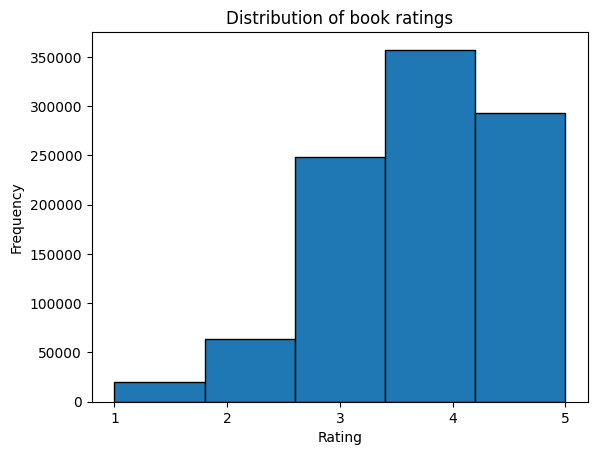

In [4]:
plt.hist(ratings.rating, bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.xticks(range(1, 6))
plt.ylabel('Frequency')
plt.title('Distribution of book ratings')
plt.show()

## Датасет и даталоадер

Напишем класс датасета.

In [22]:
# Класс датасета
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.book_ids = df['book_id'].values
        self.user_ids = df['user_id'].values
        self.ratings = df['rating'].values

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        book_id = torch.tensor(self.book_ids[idx], dtype=torch.long)
        user_id = torch.tensor(self.user_ids[idx], dtype=torch.long)
        rating = torch.tensor(self.ratings[idx], dtype=torch.float)
        return book_id, user_id, rating

Разобьём данные на обучающую и тестовую выборки в отношении 4:1.В качестве значения параметра random_state возьмём по традиции число 42.

In [8]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
print(train.shape)

(785404, 3)


Создадим наборы данных и обернём их в класс загрузчика.

In [36]:
train_dataset = RatingsDataset(train)
test_dataset = RatingsDataset(test)

batch_size = 32
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
)

## Моделирование

### Имплементация в pytorch

Напишем класс модели.

In [26]:
class RecommendationModel(nn.Module):
    def __init__(self, n_books, n_users, embedding_dim):
        super(RecommendationModel, self).__init__()

        self.book_embedding = nn.Embedding(n_books + 1, embedding_dim)
        self.user_embedding = nn.Embedding(n_users + 1, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, book_id, user_id):
        book_vec = self.book_embedding(book_id)  # (batch_size, embedding_dim)
        user_vec = self.user_embedding(user_id)  # (batch_size, embedding_dim)

        # Объединяем векторы книг и пользователей
        concatenated = torch.cat((book_vec, user_vec), dim=1)  # (batch_size, embedding_dim*2)

        x = F.relu(self.fc1(concatenated))
        x = F.relu(self.fc2(x))
        output = self.output(x)
        return output

Инициализируем модель и выведем саммари.

In [37]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RecommendationModel(n_books, n_users, 5).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
summary(model)

Layer (type:depth-idx)                   Param #
RecommendationModel                      --
├─Embedding: 1-1                         50,005
├─Embedding: 1-2                         267,125
├─Linear: 1-3                            1,408
├─Linear: 1-4                            4,128
├─Linear: 1-5                            33
Total params: 322,699
Trainable params: 322,699
Non-trainable params: 0

In [38]:
N_EPOCHS = 6
train_losses = []
test_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    optimizer.zero_grad()
    total_loss = 0
    for batch in train_bar:
        book_id = batch[0].to(device)
        user_id = batch[1].to(device)
        rating = batch[2].to(device)
        outputs = model(book_id, user_id)
        loss = criterion(outputs, rating.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_bar.set_description(desc="T[%d/%d] Loss: %.4f" % (epoch, N_EPOCHS, loss.item()))
    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    val_bar = tqdm(test_loader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_bar:
            book_id = batch[0].to(device)
            user_id = batch[1].to(device)
            rating = batch[2].to(device)
            outputs = model(book_id, user_id)
            loss = criterion(outputs, rating.unsqueeze(1))
            total_loss += loss.item()
            val_bar.set_description(desc="V[%d/%d] Loss: %.4f" % (epoch, N_EPOCHS, loss.item()))
    test_loss = total_loss / len(test_loader)
    test_losses.append(test_loss)
    
    lr_scheduler.step()

V[6/6] Loss: 0.8596: 100%|██████████| 6136/6136 [00:25<00:00, 241.25it/s]


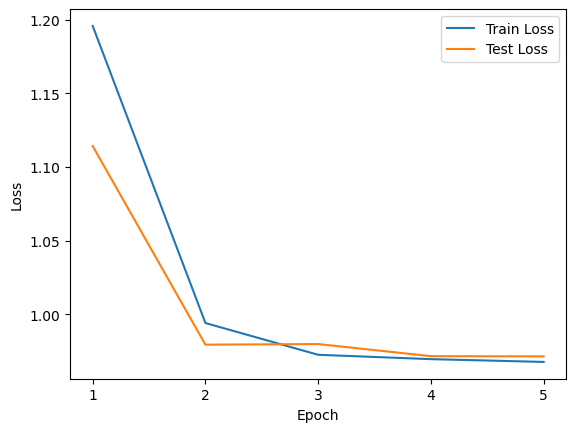

In [42]:
plt.plot(np.arange(1, N_EPOCHS), train_losses[1:], label='Train Loss')
plt.plot(np.arange(1, N_EPOCHS), test_losses[1:], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, N_EPOCHS))
plt.legend()
plt.show()

In [43]:
print(f'Минимальный MSE в среднем по пакетам: {min(test_losses): .4f}')

Минимальный MSE в среднем по пакетам:  0.9713


### Имплементация в keras

In [13]:
embedding_dim = 5
# эмбеддинги для книг
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, embedding_dim, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)
# эмбеддинги для пользователей
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# конкатенация эмбеддингов
conc = Concatenate()([book_vec, user_vec])
# полносвязки и выходной слой
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# сборка модели
model = Model([user_input, book_input], out)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Book-Input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Book-Embedding      │ (None, 1, 5)      │     50,005 │ Book-Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Embedding      │ (None, 1, 5)      │    267,125 │ User-Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten-Books       │ (None, 5)         │          0 │ Book-Embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten-Users       │ (None, 5)         │          0 │ User-Embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 10)        │          0 │ Flatten-Books[0]… │
│ (Concatenate)       │                   │            │ Flatten-Users[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      1,408 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      4,128 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 322,699 (1.23 MB)

 Trainable params: 322,699 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Архитектура и число параметров идентичны. Соберём модель с оптимизатором и loss-функцией.

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

С данными можно работать без оборачиваний датафреймов в дополнительный класс. Обучение модели:

In [15]:
# Обучение модели с валидацией
history = model.fit(
    [train.user_id, train.book_id], train.rating, 
    validation_data=([test.user_id, test.book_id], test.rating),
    epochs=N_EPOCHS, verbose=1
)

Epoch 1/6
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.9993 - val_loss: 0.7381
Epoch 2/6
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6798 - val_loss: 0.7285
Epoch 3/6
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6520 - val_loss: 0.7051
Epoch 4/6
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6273 - val_loss: 0.7101
Epoch 5/6
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6053 - val_loss: 0.7133
Epoch 6/6
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.5853 - val_loss: 0.7121


Валидация:

In [16]:
model.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.7111


0.7121403813362122

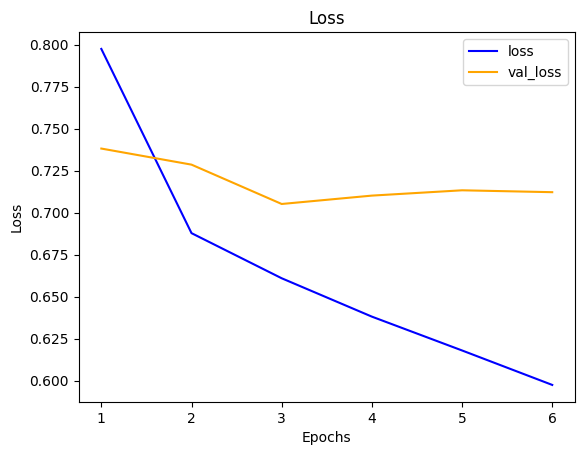

In [21]:
# Визуализация графиков потерь
plt.plot(np.arange(1, N_EPOCHS+1), history.history['loss'], label='loss', color='blue')
plt.plot(np.arange(1, N_EPOCHS+1), history.history['val_loss'], label='val_loss', color='orange')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [45]:
print(f"Минимальный MSE в среднем по пакетам: {min(history.history['val_loss']): .4f}")

Минимальный MSE в среднем по пакетам:  0.7051
